In [145]:
import numpy as np
import matplotlib as mpl
mpl.use("Agg")
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
from matplotlib import pyplot as plt
%matplotlib notebook

In [146]:
BENCHMARKS_DIR = 'bifrost/test/benchmarks/'
SERIAL_BENCHMARKS_DIR = BENCHMARKS_DIR + 'performance_vs_serial/'

In [147]:
benchmarks_file = open(SERIAL_BENCHMARKS_DIR + 'benchmarks5.log.txt', 'r')
# FFT's/2, size multiplier, gulp size, gulp frame read, gulp frame fft, ..., ..., speedup
aws_benchmarks = np.genfromtxt(
    (",".join(ln.split(',')[1:-1]) for ln in benchmarks_file),
    dtype=np.float32,
    delimiter=',');

In [148]:
i_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': 2,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': 4,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Log2 the data, and extract a slice for plotting:

In [166]:
cur_benchmarks = np.copy(aws_benchmarks)
cur_benchmarks[:, i_map['gulp_size']] = np.log2(cur_benchmarks[:, i_map['gulp_size']]/32768)
cur_benchmarks[:, i_map['gulp_nframe_fft']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_fft']])

x_axis = 'gulp_size' #second of [1, 2]
y_axis = 'gulp_nframe_fft' #first of [1, 2]

data_slice = {
    'fft_number': 1,
    'size_multiplier': 1,
    'gulp_nframe_read': 2
}

index_possible_choices = [cur_benchmarks[:, i_map[key]] == data_slice[key] for key in data_slice.keys()]

index_shared_choices = np.bitwise_and.reduce(index_choice_list)

indices = np.argwhere(index_shared_choices[:])

data_to_plot = cur_benchmarks[indices, [i_map[y_axis], i_map[x_axis], -1]]



range_array = lambda ar: np.max(ar) - np.min(ar)

shape_display_y = int(range_array(data_to_plot[:, 0]) + 1)
shape_display_x = int(range_array(data_to_plot[:, 1]) + 1)

# Last axis is always x-axis in an imshow!
plot_shape = (shape_display_y, shape_display_x)

display_plot = np.zeros(plot_shape)

display_plot[data_to_plot[:, 0].astype(np.int), data_to_plot[:, 1].astype(np.int)] = data_to_plot[:, 2]

# Plot the data:

<IPython.core.display.Javascript object>


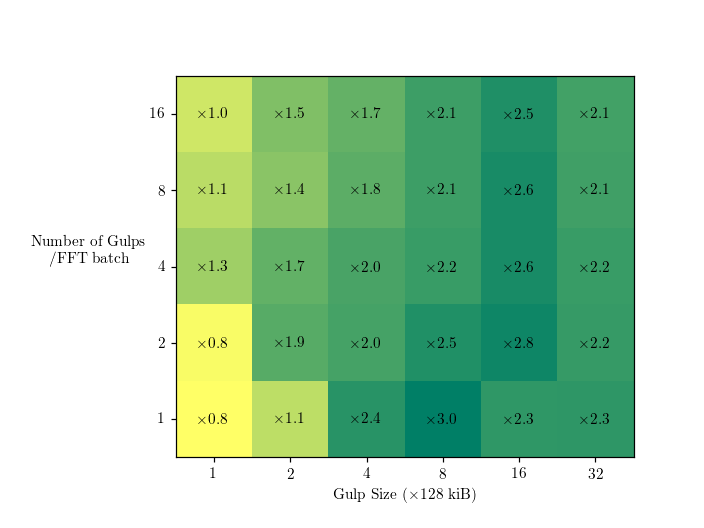

In [186]:
%matplotlib notebook

fig, ax1 = plt.subplots(1,1)
from matplotlib.colors import LogNorm

# Title:
title_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': "Gulp Size"r" ($\times$128 kiB)",
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': "Number of Gulps\n/FFT batch",
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Title:
tick_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': lambda i: 2**i,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': lambda i: 2**i,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Log color scale
norm = LogNorm(vmin=np.min(display_plot), vmax=np.max(display_plot))

im = ax1.imshow(
    display_plot,
    cmap='summer_r', origin='lower', norm=norm)
ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=40)
ax1.set_xlabel(title_map[x_axis]);

ax1.set_xticks([i for i in range(display_plot.shape[1])])
ax1.set_yticks([i for i in range(display_plot.shape[0])])
ax1.set_xticklabels([tick_map[x_axis](i) for i in range(display_plot.shape[1])])
ax1.set_yticklabels([tick_map[y_axis](i) for i in range(display_plot.shape[0])])

"""
ax1.set_xticks([i for i in range(5)])
ax1.set_xticklabels([2**i for i in range(1, 6)])
ax1.set_xlabel(r'Gulp Size ($\times$128 kiB)')
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels([1, 2, 4, 8, 16])
ax1.set_ylabel(r'Number Gulps''\n'r'per batch',rotation=0, labelpad=40)
cbar = fig.colorbar(im, shrink=0.4, ticks=[np.min(rel_display_plot), 1.0, 2])
cbar.ax.set_yticklabels(['Slower', 'Same', 'Faster'])  # vertically oriented colorbar
cbar.ax.text(13, 0.4, 'Speedup\nvs.\nskcuda', rotation=0, 
        horizontalalignment='center')

fig.savefig('bifrost/speedup.pdf', bbox_inches='tight')
""";

for (j,i),label in np.ndenumerate(display_plot):
    ax1.text(i, j, r'$\times$%.1f'%label, ha='center', va='center')
fig.subplots_adjust(left=0.25)

# Caption ideas

Should emphasize:
- This pipeline was not tuned in any way, it is vanilla Bifrost code, with no core bindings set, and no block fusion enabled.
- Not only do you get more speed for same effort, but you get greater functionality for same effort (bf.map!)
- Easy to switch it to a real-time pipeline for a telescope
- These plots aren't meant to show anything particular about when Bifrost is useful and when it isn't, they are supposed to show the trend of where Bifrost becomes very effective: large gulp sizes and large amounts of data.
- Bottom slower for Bifrost because of the greater Python overhead incurred from small gulp sizes. Small effort tuning gulp sizes eliminates this.
- Both pipelines are GPU-based FFT pipelines, controlled in Python. Similar (say exactly) source lines of code. Through pipeline-parallelism, Bifrost achieves a speedup using the same underlying cuFFT functionality.
- Emphasize that a hand-tuned C or C++ pipeline compiled with optimization can be faster than Bifrost. However, due to the development effort associated with writing a stream-processing pipeline by hand, Bifrost is a competitive alternative.